# Identifying Similar Questions

In this notebook, I will be performing Exploratory Data Analysis (EDA) and preprocessing the datasets for training

**Imports**

In [3]:
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
import torch
import warnings
import nltk
from tqdm import tqdm # Progress Bar
from nltk.corpus import stopwords
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

**Import the data**

https://www.kaggle.com/mysarahmadbhat/quora-questions-duplicacy

In [4]:
df = pd.read_csv('./quora.csv', index_col=0)

In [5]:
df.head()

,index,id,qid1,qid2,question1,question2,is_duplicate
0,8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
1,368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
2,70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
3,226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
4,73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         100000 non-null  int64 
 1   id            100000 non-null  int64 
 2   qid1          100000 non-null  int64 
 3   qid2          100000 non-null  int64 
 4   question1     100000 non-null  object
 5   question2     100000 non-null  object
 6   is_duplicate  100000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 6.1+ MB


Dropping any duplicates (If Existing)

In [7]:
df.drop_duplicates(inplace=True)

Looking for missing values

In [8]:
df.isna().sum()

index           0
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

Number of labels

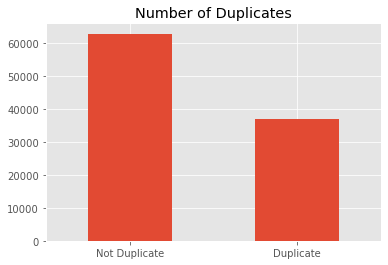

In [9]:
df['is_duplicate'].value_counts().plot.bar()
plt.title('Number of Duplicates')
plt.xticks([0,1],['Not Duplicate','Duplicate'], rotation=0);

The dataset is imbalanced when it comes to labels

**Calculating the word lengths of each set of questions**

In [10]:
df["question1_wc"] = df["question1"].apply(lambda x: len(x.split(' ')))
df["question2_wc"] = df["question2"].apply(lambda x: len(x.split(' ')))

In [11]:
df[['question1','question2','question1_wc','question2_wc','is_duplicate']].head()

,question1,question2,question1_wc,question2_wc,is_duplicate
0,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,8,8,0
1,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,11,9,0
2,Which is more advisable and better material fo...,What is the best server setup for buddypress?,16,8,0
3,How do I improve logical programming skills?,How can I improve my logical skills for progra...,7,9,1
4,How close we are to see 3rd world war?,How close is a World War III?,9,7,1


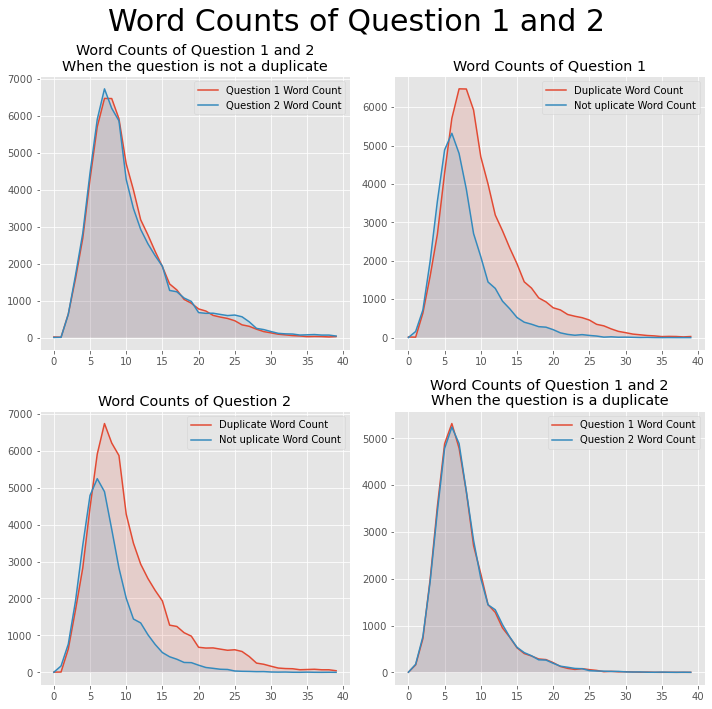

In [12]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
num_range = 40
x = np.arange(0, num_range)
alpha = 0.15

plt.sca(axes[0,0])
y1 = df[df['is_duplicate']==0]['question1_wc'].value_counts().sort_index().values[:num_range]
y2 = df[df['is_duplicate']==0]['question2_wc'].value_counts().sort_index().values[:num_range]
plt.fill_between(x, y1, alpha=alpha)
plt.fill_between(x, y2, alpha=alpha)
plt.plot(x, y1, label='Question 1 Word Count')
plt.plot(x, y2, label='Question 2 Word Count')
plt.title('Word Counts of Question 1 and 2\nWhen the question is not a duplicate')
plt.legend()

plt.sca(axes[0,1])
y1 = df[df['is_duplicate']==0]['question1_wc'].value_counts().sort_index().values[:num_range]
y2 = df[df['is_duplicate']==1]['question1_wc'].value_counts().sort_index().values[:num_range]
plt.fill_between(x, y1, alpha=alpha)
plt.fill_between(x, y2, alpha=alpha)
plt.plot(x, y1, label='Duplicate Word Count')
plt.plot(x, y2, label='Not uplicate Word Count')
plt.title('Word Counts of Question 1')
plt.legend()

plt.sca(axes[1,0])
y1 = df[df['is_duplicate']==0]['question2_wc'].value_counts().sort_index().values[:num_range]
y2 = df[df['is_duplicate']==1]['question2_wc'].value_counts().sort_index().values[:num_range]
plt.fill_between(x, y1, alpha=alpha)
plt.fill_between(x, y2, alpha=alpha)
plt.plot(x, y1, label='Duplicate Word Count')
plt.plot(x, y2, label='Not uplicate Word Count')
plt.title('Word Counts of Question 2')
plt.legend()

plt.sca(axes[1,1])
y1 = df[df['is_duplicate']==1]['question1_wc'].value_counts().sort_index().values[:num_range]
y2 = df[df['is_duplicate']==1]['question2_wc'].value_counts().sort_index().values[:num_range]
plt.fill_between(x, y1, alpha=alpha)
plt.fill_between(x, y2, alpha=alpha)
plt.plot(x, y1, label='Question 1 Word Count')
plt.plot(x, y2, label='Question 2 Word Count')
plt.title('Word Counts of Question 1 and 2\nWhen the question is a duplicate')
plt.legend()

fig.suptitle('Word Counts of Question 1 and 2', fontsize=30)
fig.tight_layout();

The word count is identical inbetween question pairs. But there are more words in questions that are labeled as duplicate than not duplicate.

**Get the difference in word counts**

In [13]:
df['q1_q2_diff'] = df['question1_wc'] - df['question2_wc']
df[['question1','question2','question1_wc','question2_wc','is_duplicate','q1_q2_diff']]

,question1,question2,question1_wc,question2_wc,is_duplicate,q1_q2_diff
0,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,8,8,0,0
1,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,11,9,0,2
2,Which is more advisable and better material fo...,What is the best server setup for buddypress?,16,8,0,8
3,How do I improve logical programming skills?,How can I improve my logical skills for progra...,7,9,1,-2
4,How close we are to see 3rd world war?,How close is a World War III?,9,7,1,2
...,...,...,...,...,...,...
99995,How do I market my software product?,How do I market a software product?,7,7,1,0
99996,I imagine stabbing people in the throat all th...,Where online can I track how the California pr...,16,15,0,1
99997,What is the best online English dictionary?,What’s the best online english dictionary?,7,6,1,1
99998,Which are some good english movies?,What are your favourite 10/10 Hollywood movies?,6,7,0,-1


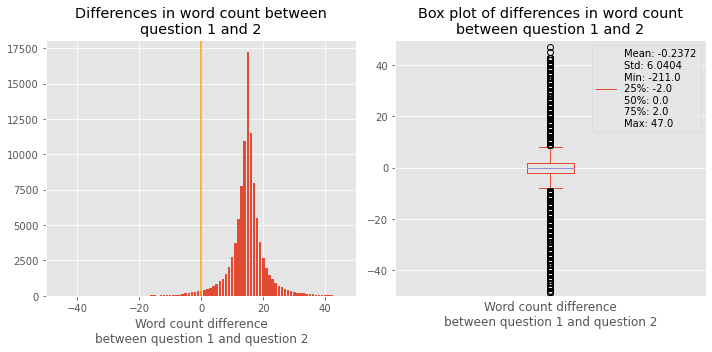

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

plt.sca(axes[0])
x = np.arange(-50,50)
y = df['q1_q2_diff'].value_counts().sort_index().values[:x.shape[0]]
plt.bar(x, y)
plt.xlim(-50,50)
plt.axvline(x=0, color='orange')
plt.title(f"Differences in word count between\nquestion 1 and 2")
plt.xlabel('Word count difference\nbetween question 1 and question 2')

plt.sca(axes[1])
df['q1_q2_diff'].plot.box()
plt.ylim(-50,50)
plt.title('Box plot of differences in word count\nbetween question 1 and 2')
plt.xticks([]) # Getting rid of the x label 
plt.xlabel('Word count difference\nbetween question 1 and question 2')
plt.legend(['Mean: ' + str(df['q1_q2_diff'].describe().loc['mean'].round(4)) + '\n' +
            'Std: ' + str(df['q1_q2_diff'].describe().loc['std'].round(4)) + '\n' +
            'Min: ' + str(df['q1_q2_diff'].describe().loc['min'].round(4)) + '\n' +
            '25%: ' + str(df['q1_q2_diff'].describe().loc['25%'].round(4)) + '\n' +
            '50%: ' + str(df['q1_q2_diff'].describe().loc['50%'].round(4)) + '\n' +
            '75%: ' + str(df['q1_q2_diff'].describe().loc['75%'].round(4)) + '\n' +
            'Max: ' + str(df['q1_q2_diff'].describe().loc['max'].round(4))])

fig.tight_layout();

**How many unqiue questions and how many questions have duplicates**

*Question 1*

In [15]:
q1_dups = pd.DataFrame(df['question1'].value_counts()[(df['question1'].value_counts() > 1).values])
print(f"There are {len(df['question1'].unique())} unique questions and {q1_dups.shape[0]} have duplicates")
q1_dups[:10]

There are 87006 unique questions and 8367 have duplicates


,question1
How do I improve my English speaking?,18
Why do people often ask questions in Quora while they can Google it themselves?,16
What are the best ways to lose weight fast?,15
How can changing 500 and 1000 rupee notes end the black money in India?,14
What is purpose of life?,13
Why do people ask questions on Quora that can easily be answered by Google?,13
What are ways I can make money online?,12
Why does quora mark my questions as needing improvement?,12
What's your new year resolution for 2017?,12
How do I improve my pronunciation of English?,12


*Question 2*

In [16]:
q2_dups = pd.DataFrame(df['question2'].value_counts()[(df['question2'].value_counts() > 1).values])
print(f"There are {len(df['question2'].unique())} unique questions and {q2_dups.shape[0]} have duplicates")
q2_dups[:10]

There are 87325 unique questions and 7457 have duplicates


,question2
What are the best ways to lose weight?,29
How can I lose weight quickly?,26
How can you look at someone's private Instagram account without following them?,23
Which is the best digital marketing course?,17
What are some things new employees should know going into their first day at AT&T?,17
What's the easiest way to make money online?,17
How do you make money online?,14
What is the best phone to buy below 15k?,14
How can I become fluent in English?,14
How could I make money online?,14


## Looking at cosine similarity between questions

For generating embeddings, I will be using SBERT to generate the embeddings

**Load the Sentence Embedding Model**

In [17]:
bert_model = SentenceTransformer('bert-large-nli-mean-tokens', device='cuda')

### Getting all the SBERT embeddings

*This can take a while to execute. 30+ minutes on the entire dataset!*

In [18]:
# q1_embeddings_list = []
# q2_embeddings_list = []

# for i in tqdm(range(df.shape[0])):
#     q1 = df.at[i, 'question1']
#     q2 = df.at[i, 'question2']
#     embeddings = bert_model.encode([q1, q2])
#     q1_embeddings_list.append(embeddings[0])
#     q2_embeddings_list.append(embeddings[1])

### Saving the embeddings as a dataframe with the labels ###

# df_embeddings = pd.DataFrame(np.hstack((q1_embeddings_list, 
#                                         q2_embeddings_list, 
#                                         df['is_duplicate'].values.reshape(-1,1)))).to_csv('quora_embeddings.csv', index=False)

*Loading the dataframe instead of re-running code*

In [19]:
df_embeddings = pd.read_csv('./quora_embeddings.csv')
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,0.405561,0.351042,0.145522,1.000624,-0.327835,-0.690683,0.415534,0.378593,-0.070010,0.595209,...,0.324852,-0.490256,-0.671185,0.091470,0.934359,0.534707,-0.032896,-0.541392,-1.225177,0.0
1,0.300924,-0.955288,-0.028438,-0.057767,-0.116978,0.664040,0.017739,0.994033,1.217564,-0.297647,...,-0.696291,-0.581999,-2.126769,0.236446,0.657223,-0.261457,0.327333,-0.159874,-0.559062,0.0
2,0.394129,-0.020451,0.822735,0.161385,0.290848,0.527879,-0.340961,-0.327334,-0.228196,0.501748,...,-0.211299,-0.892678,-1.750959,0.175476,0.429432,0.389655,0.212048,0.102080,-0.588654,0.0
3,0.256092,-1.279762,0.247349,-0.618753,0.534039,0.612880,0.307272,0.100198,-0.832151,0.879472,...,-0.398293,-0.139095,-0.957269,0.427750,0.424172,0.942060,0.083971,-1.021245,-0.237951,1.0
4,0.348143,0.070992,0.533568,0.676788,0.621202,-0.213371,0.060178,0.110749,-0.582947,0.738962,...,0.887324,-1.132204,-0.505966,0.084157,-0.245989,0.200148,0.362305,-0.552422,-0.970416,1.0


In [20]:
df_embeddings.shape

(100000, 2049)

There are 100,000 rows where each row has 2049 different values

**Looking at the questions with their labels and cosine similarities**

In [21]:
index = 0
q1 = df.at[index, 'question1']
q2 = df.at[index, 'question2']
is_dup = df.at[index, 'is_duplicate']
embeddings = bert_model.encode([q1, q2])
print(q1, q2, sep='\n')
print('Duplicate') if is_dup else print('Not Duplicate')
print(float(util.pytorch_cos_sim(embeddings[0], embeddings[1])[0][0]))

How do I play Pokémon GO in Korea?
How do I play Pokémon GO in China?
Not Duplicate
0.7900386452674866


In [22]:
index = 1
q1 = df.at[index, 'question1']
q2 = df.at[index, 'question2']
is_dup = df.at[index, 'is_duplicate']
embeddings = bert_model.encode([q1, q2])
print(q1, q2, sep='\n')
print('Duplicate') if is_dup else print('Not Duplicate')
print(float(util.pytorch_cos_sim(embeddings[0], embeddings[1])[0][0]))

What are some of the best side dishes for crab cakes?
What are some good side dishes for buffalo chicken?
Not Duplicate
0.676845133304596


In [23]:
index = 9
q1 = df.at[index, 'question1']
q2 = df.at[index, 'question2']
is_dup = df.at[index, 'is_duplicate']
embeddings = bert_model.encode([q1, q2])
print(q1, q2, sep='\n')
print('Duplicate') if is_dup else print('Not Duplicate')
print(float(util.pytorch_cos_sim(embeddings[0], embeddings[1])[0][0]))

How do I improve logical programming skills?
What is the best way to improve logical skills in programming?
Duplicate
0.9723871946334839


**Getting all the cosine similiarity and distances** 

In [24]:
# cs_list = []
# distance_list = []

# for i in tqdm(range(df.shape[0])):
#     ### Cosine Similarity
#     cs_list.append(float(util.pytorch_cos_sim(df_embeddings.iloc[i][:1024], df_embeddings.iloc[i][1024:2048])[0][0]))
#     ### Distance
#     distance_list.append(np.linalg.norm(np.array(df_embeddings.iloc[i][:1024]) - np.array(df_embeddings.iloc[i][1024:2048])))
    
### Saving the distances as a dataframe with the labels ###
    
# pd.DataFrame(np.hstack((np.array(cs_list).reshape(-1,1), 
#                         np.array(distance_list).reshape(-1,1), 
#                         df['is_duplicate'].values.reshape(-1,1)))).to_csv('quora_cosine_distance.csv', index=False)

# df_cos_dist = pd.read_csv('./quora_cosine_distance.csv')
# df_cos_dist.rename(columns={'0':'Cosine Similarity', '1':'Distance', '2':'is_duplicate'}, inplace=True)
# df_cos_dist.to_csv('quora_cosine_distance.csv', index=False)

In [25]:
df_cos_dist = pd.read_csv('./quora_cosine_distance.csv')
df_cos_dist.head()

,Cosine Similarity,Distance,is_duplicate
0,0.790038,12.539657,0.0
1,0.676845,16.660674,0.0
2,0.486623,18.434176,0.0
3,0.972164,4.558162,1.0
4,0.781517,12.744262,1.0


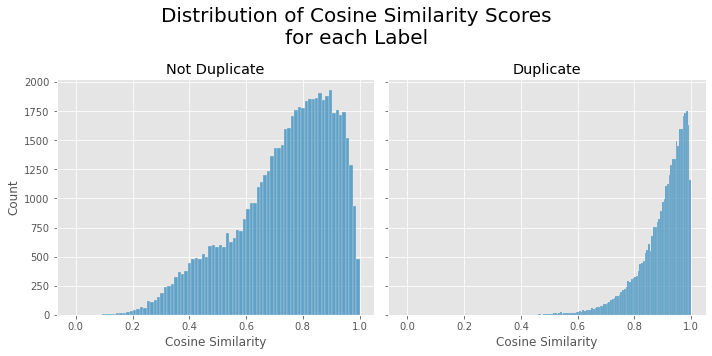

In [26]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))

sns.histplot(df_cos_dist['Cosine Similarity'][df_cos_dist['is_duplicate'] == 0], ax=axes[0])
plt.sca(axes[0])
plt.title('Not Duplicate')
sns.histplot(df_cos_dist['Cosine Similarity'][df_cos_dist['is_duplicate'] == 1], ax=axes[1])
plt.sca(axes[1])
plt.title('Duplicate')
fig.suptitle('Distribution of Cosine Similarity Scores\nfor each Label', fontsize=20)
fig.tight_layout();

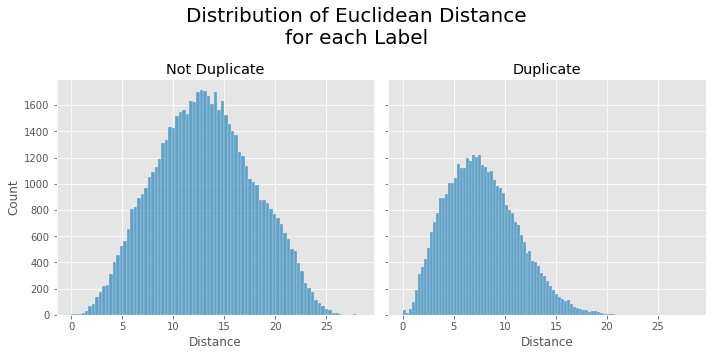

In [27]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))

sns.histplot(df_cos_dist['Distance'][df_cos_dist['is_duplicate'] == 0], ax=axes[0])
plt.sca(axes[0])
plt.title('Not Duplicate')
sns.histplot(df_cos_dist['Distance'][df_cos_dist['is_duplicate'] == 1], ax=axes[1])
plt.sca(axes[1])
plt.title('Duplicate')
fig.suptitle('Distribution of Euclidean Distance\nfor each Label', fontsize=20)
fig.tight_layout();

## Cleaning the questions and re-computing the embeddings

*Loading Stopwords*

In [28]:
stop_words = stopwords.words('english')

*Loading Stemmer*

In [29]:
stemmer = nltk.SnowballStemmer("english")

*This function makes text lowercase, remove text in square brackets, remove links, remove punctuation, remove stopwords, use stemming, and remove words containing numbers.*

In [30]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    # Remove Stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Stemming
    text = ' '.join(stemmer.stem(word) for word in text.split())
    
    # Fixing extra whitespaces between words
    text = ' '.join(text.split())
    return text

*Cleaning the responses*

In [31]:
df['question1_cleaned'] = df['question1'].apply(clean_text)
df['question2_cleaned'] = df['question2'].apply(clean_text)

In [32]:
df.head()

,index,id,qid1,qid2,question1,question2,is_duplicate,question1_wc,question2_wc,q1_q2_diff,question1_cleaned,question2_cleaned
0,8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,8,8,0,play pokémon go korea,play pokémon go china
1,368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,11,9,2,best side dish crab cake,good side dish buffalo chicken
2,70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,16,8,8,advis better materi crash test automobil ducti...,best server setup buddypress
3,226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,7,9,-2,improv logic program skill,improv logic skill program
4,73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,9,7,2,close see world war,close world war iii


In [33]:
df[['question1_cleaned','question2_cleaned']].head()

,question1_cleaned,question2_cleaned
0,play pokémon go korea,play pokémon go china
1,best side dish crab cake,good side dish buffalo chicken
2,advis better materi crash test automobil ducti...,best server setup buddypress
3,improv logic program skill,improv logic skill program
4,close see world war,close world war iii


Getting the word counts of the cleaned questions

In [34]:
df["question1_cleaned_wc"] = df["question1_cleaned"].apply(lambda x: len(x.split(' ')))
df["question2_cleaned_wc"] = df["question2_cleaned"].apply(lambda x: len(x.split(' ')))

In [35]:
df[['question1_cleaned','question2_cleaned','question1_cleaned_wc','question2_cleaned_wc','is_duplicate']].head()

,question1_cleaned,question2_cleaned,question1_cleaned_wc,question2_cleaned_wc,is_duplicate
0,play pokémon go korea,play pokémon go china,4,4,0
1,best side dish crab cake,good side dish buffalo chicken,5,5,0
2,advis better materi crash test automobil ducti...,best server setup buddypress,8,4,0
3,improv logic program skill,improv logic skill program,4,4,1
4,close see world war,close world war iii,4,4,1


Looking at the word count differences

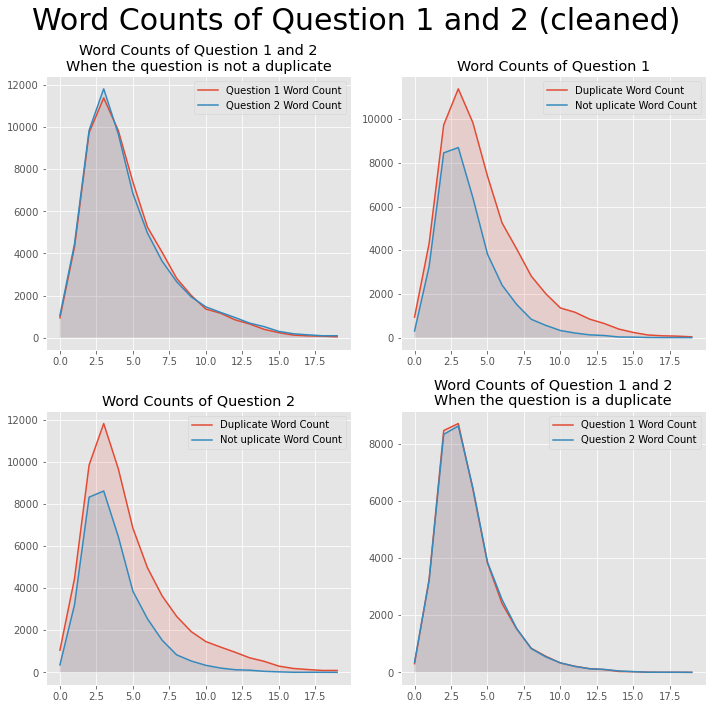

In [36]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
num_range = 20
x = np.arange(0, num_range)
alpha = 0.15

plt.sca(axes[0,0])
y1 = df[df['is_duplicate']==0]['question1_cleaned_wc'].value_counts().sort_index().values[:num_range]
y2 = df[df['is_duplicate']==0]['question2_cleaned_wc'].value_counts().sort_index().values[:num_range]
plt.fill_between(x, y1, alpha=alpha)
plt.fill_between(x, y2, alpha=alpha)
plt.plot(x, y1, label='Question 1 Word Count')
plt.plot(x, y2, label='Question 2 Word Count')
plt.title('Word Counts of Question 1 and 2\nWhen the question is not a duplicate')
plt.legend()

plt.sca(axes[0,1])
y1 = df[df['is_duplicate']==0]['question1_cleaned_wc'].value_counts().sort_index().values[:num_range]
y2 = df[df['is_duplicate']==1]['question1_cleaned_wc'].value_counts().sort_index().values[:num_range]
plt.fill_between(x, y1, alpha=alpha)
plt.fill_between(x, y2, alpha=alpha)
plt.plot(x, y1, label='Duplicate Word Count')
plt.plot(x, y2, label='Not uplicate Word Count')
plt.title('Word Counts of Question 1')
plt.legend()

plt.sca(axes[1,0])
y1 = df[df['is_duplicate']==0]['question2_cleaned_wc'].value_counts().sort_index().values[:num_range]
y2 = df[df['is_duplicate']==1]['question2_cleaned_wc'].value_counts().sort_index().values[:num_range]
plt.fill_between(x, y1, alpha=alpha)
plt.fill_between(x, y2, alpha=alpha)
plt.plot(x, y1, label='Duplicate Word Count')
plt.plot(x, y2, label='Not uplicate Word Count')
plt.title('Word Counts of Question 2')
plt.legend()

plt.sca(axes[1,1])
y1 = df[df['is_duplicate']==1]['question1_cleaned_wc'].value_counts().sort_index().values[:num_range]
y2 = df[df['is_duplicate']==1]['question2_cleaned_wc'].value_counts().sort_index().values[:num_range]
plt.fill_between(x, y1, alpha=alpha)
plt.fill_between(x, y2, alpha=alpha)
plt.plot(x, y1, label='Question 1 Word Count')
plt.plot(x, y2, label='Question 2 Word Count')
plt.title('Word Counts of Question 1 and 2\nWhen the question is a duplicate')
plt.legend()

fig.suptitle('Word Counts of Question 1 and 2 (cleaned)', fontsize=30)
fig.tight_layout();

**Get the difference in word counts from the cleaned responses**

In [37]:
df['q1_q2_diff_cleaned'] = df['question1_cleaned_wc'] - df['question2_cleaned_wc']
df[['question1_cleaned','question2_cleaned','question1_cleaned_wc','question2_cleaned_wc','is_duplicate','q1_q2_diff_cleaned']].head()

,question1_cleaned,question2_cleaned,question1_cleaned_wc,question2_cleaned_wc,is_duplicate,q1_q2_diff_cleaned
0,play pokémon go korea,play pokémon go china,4,4,0,0
1,best side dish crab cake,good side dish buffalo chicken,5,5,0,0
2,advis better materi crash test automobil ducti...,best server setup buddypress,8,4,0,4
3,improv logic program skill,improv logic skill program,4,4,1,0
4,close see world war,close world war iii,4,4,1,0


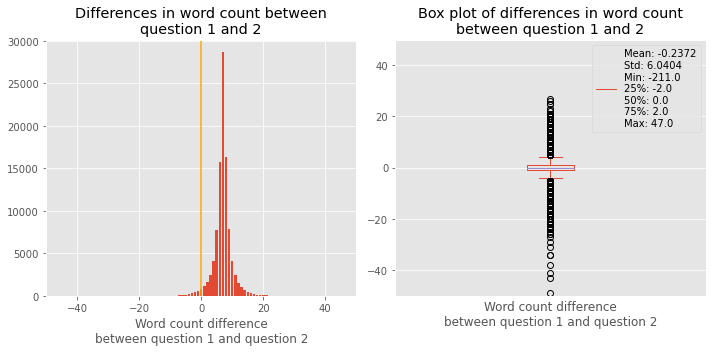

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

plt.sca(axes[0])
x = np.arange(-30,30)
y = df['q1_q2_diff_cleaned'].value_counts().sort_index().values[:x.shape[0]]
plt.bar(x, y)
plt.xlim(-50,50)
plt.axvline(x=0, color='orange')
plt.title(f"Differences in word count between\nquestion 1 and 2")
plt.xlabel('Word count difference\nbetween question 1 and question 2')

plt.sca(axes[1])
df['q1_q2_diff_cleaned'].plot.box()
plt.ylim(-50,50)
plt.title('Box plot of differences in word count\nbetween question 1 and 2')
plt.xticks([]) # Getting rid of the x label 
plt.xlabel('Word count difference\nbetween question 1 and question 2')
plt.legend(['Mean: ' + str(df['q1_q2_diff'].describe().loc['mean'].round(4)) + '\n' +
            'Std: ' + str(df['q1_q2_diff'].describe().loc['std'].round(4)) + '\n' +
            'Min: ' + str(df['q1_q2_diff'].describe().loc['min'].round(4)) + '\n' +
            '25%: ' + str(df['q1_q2_diff'].describe().loc['25%'].round(4)) + '\n' +
            '50%: ' + str(df['q1_q2_diff'].describe().loc['50%'].round(4)) + '\n' +
            '75%: ' + str(df['q1_q2_diff'].describe().loc['75%'].round(4)) + '\n' +
            'Max: ' + str(df['q1_q2_diff'].describe().loc['max'].round(4))])

fig.tight_layout();

**Generating the embeddings for the cleaned questions**

In [39]:
# q1_embeddings_list = []
# q2_embeddings_list = []

# for i in tqdm(range(df.shape[0])):
#     q1 = df.at[i, 'question1_cleaned']
#     q2 = df.at[i, 'question2_cleaned']
#     embeddings = bert_model.encode([q1, q2])
#     q1_embeddings_list.append(embeddings[0])
#     q2_embeddings_list.append(embeddings[1])

# ## Saving the embeddings as a dataframe with the labels ###

# pd.DataFrame(np.hstack((q1_embeddings_list, 
#                         q2_embeddings_list, 
#                         df['is_duplicate'].values.reshape(-1,1)))).to_csv('quora_cleaned_embeddings.csv', index=False)

In [40]:
df_cleaned_embeddings = pd.read_csv('./quora_cleaned_embeddings.csv')
df_cleaned_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,0.099863,0.804212,0.457976,1.360421,-0.439485,-0.542794,0.622026,-0.005323,0.216617,0.420137,...,0.198325,-0.638950,-0.256670,-0.147607,0.427118,0.315945,-0.052933,-0.446774,-0.929896,0.0
1,0.579055,-0.467236,-0.014480,0.050153,-0.338045,0.431639,-0.103256,0.700369,1.370580,-0.389891,...,-0.860721,-0.555505,-1.613838,-0.139364,0.284707,-0.446280,0.189698,-0.195710,-0.583254,0.0
2,0.295399,-0.071162,0.662856,0.133914,-0.059055,0.359554,-0.350415,-0.725764,0.231294,0.224926,...,-0.308801,-0.583140,-1.033460,0.000881,-0.071482,-0.163930,-0.425215,0.229150,-0.357686,0.0
3,-0.179769,-0.170566,0.261266,-0.477791,-0.310139,0.050823,-0.390488,-0.373177,-0.800839,0.782366,...,-1.031234,-0.424010,-1.140022,-0.059757,0.505181,0.662573,0.303810,-0.766564,0.073204,1.0
4,0.013538,0.066066,1.023784,0.517954,0.606080,0.089296,0.049157,-0.592669,-0.022250,0.444191,...,0.170532,-1.291750,0.085144,-0.049792,-0.246931,0.490173,0.197307,-0.669707,-0.590559,1.0


**Taking a look at the questions and their labels with cosine similarities**

In [41]:
index = 0
q1 = df.at[index, 'question1_cleaned']
q2 = df.at[index, 'question2_cleaned']
is_dup = df.at[index, 'is_duplicate']
embeddings = bert_model.encode([q1, q2])
print(q1, q2, sep='\n')
print('Duplicate') if is_dup else print('Not Duplicate')
print(float(util.pytorch_cos_sim(embeddings[0], embeddings[1])[0][0]))

play pokémon go korea
play pokémon go china
Not Duplicate
0.7423173189163208


In [42]:
index = 1
q1 = df.at[index, 'question1_cleaned']
q2 = df.at[index, 'question2_cleaned']
is_dup = df.at[index, 'is_duplicate']
embeddings = bert_model.encode([q1, q2])
print(q1, q2, sep='\n')
print('Duplicate') if is_dup else print('Not Duplicate')
print(float(util.pytorch_cos_sim(embeddings[0], embeddings[1])[0][0]))

best side dish crab cake
good side dish buffalo chicken
Not Duplicate
0.5670937895774841


In [43]:
index = 9
q1 = df.at[index, 'question1_cleaned']
q2 = df.at[index, 'question2_cleaned']
is_dup = df.at[index, 'is_duplicate']
embeddings = bert_model.encode([q1, q2])
print(q1, q2, sep='\n')
print('Duplicate') if is_dup else print('Not Duplicate')
print(float(util.pytorch_cos_sim(embeddings[0], embeddings[1])[0][0]))

improv logic program skill
best way improv logic skill program
Duplicate
0.8393554091453552


**Generating the cosine similarities and euclidean distance from embeddings**

In [44]:
# cs_list = []
# distance_list = []

# for i in tqdm(range(df.shape[0])):
#     ### Cosine Similarity
#     cs_list.append(float(util.pytorch_cos_sim(df_cleaned_embeddings.iloc[i][:1024], df_cleaned_embeddings.iloc[i][1024:2048])[0][0]))
#     ### Distance
#     distance_list.append(np.linalg.norm(np.array(df_cleaned_embeddings.iloc[i][:1024]) - np.array(df_cleaned_embeddings.iloc[i][1024:2048])))
    
# ## Saving the distances as a dataframe with the labels ###
    
# pd.DataFrame(np.hstack((np.array(cs_list).reshape(-1,1),
#                         np.array(distance_list).reshape(-1,1), 
#                         df['is_duplicate'].values.reshape(-1,1)))).to_csv('quora_cleaned_cosine_distance.csv', index=False)

# df_cleaned_cos_dist = pd.read_csv('quora_cleaned_cosine_distance.csv')
# df_cleaned_cos_dist.rename(columns={'0':'Cosine Similarity', '1':'Distance', '2':'is_duplicate'}, inplace=True)
# df_cleaned_cos_dist.to_csv('quora_cleaned_cosine_distance.csv', index=False)

In [45]:
df_cleaned_cos_dist = pd.read_csv('quora_cleaned_cosine_distance.csv')
df_cleaned_cos_dist

,Cosine Similarity,Distance,is_duplicate
0,0.742317,14.112444,0.0
1,0.567094,19.397882,0.0
2,0.328242,21.186270,0.0
3,0.975745,4.006721,1.0
4,0.808538,12.107285,1.0
...,...,...,...
99995,1.000000,0.000000,1.0
99996,0.494611,19.071208,0.0
99997,0.911330,7.992453,1.0
99998,0.488034,19.409292,0.0


**Looking at the cosine simialrities and distances between duplicate and non duplicate questions**

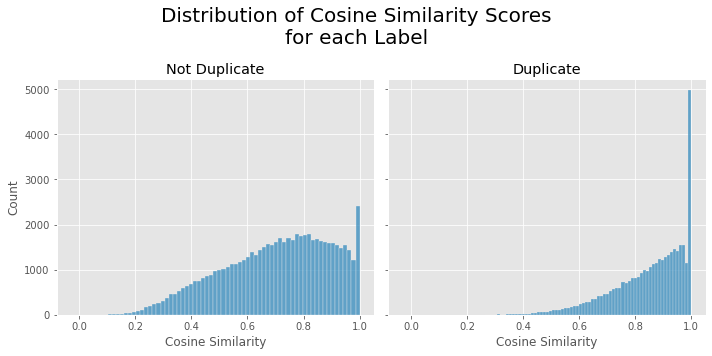

In [46]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))

sns.histplot(df_cleaned_cos_dist['Cosine Similarity'][df_cleaned_cos_dist['is_duplicate'] == 0], ax=axes[0])
plt.sca(axes[0])
plt.title('Not Duplicate')
sns.histplot(df_cleaned_cos_dist['Cosine Similarity'][df_cleaned_cos_dist['is_duplicate'] == 1], ax=axes[1])
plt.sca(axes[1])
plt.title('Duplicate')
fig.suptitle('Distribution of Cosine Similarity Scores\nfor each Label', fontsize=20)
fig.tight_layout();

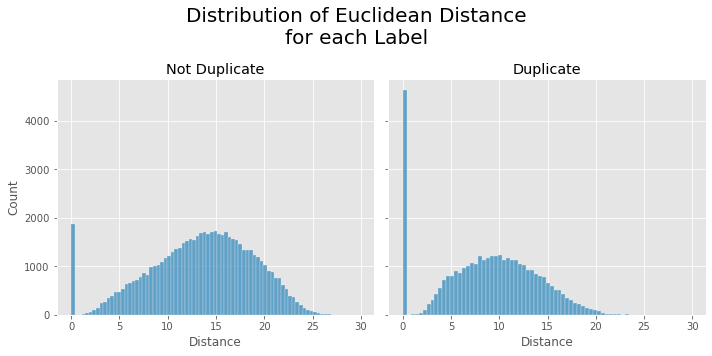

In [47]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))

sns.histplot(df_cleaned_cos_dist['Distance'][df_cleaned_cos_dist['is_duplicate'] == 0], ax=axes[0])
plt.sca(axes[0])
plt.title('Not Duplicate')
sns.histplot(df_cleaned_cos_dist['Distance'][df_cleaned_cos_dist['is_duplicate'] == 1], ax=axes[1])
plt.sca(axes[1])
plt.title('Duplicate')
fig.suptitle('Distribution of Euclidean Distance\nfor each Label', fontsize=20)
fig.tight_layout();

### Looking at the differences between the cleaned and original questions

In [48]:
(df_cos_dist['Cosine Similarity'] - df_cleaned_cos_dist['Cosine Similarity']).mean()

0.03991854970933416

The average cosine similarity increased by around 0.4

In [49]:
(df_cos_dist['Distance'] - df_cleaned_cos_dist['Distance']).mean()

-0.712053944395288

The average distance decreased by arround 0.7 

In [50]:
(df['question1_wc'] - df['question1_cleaned_wc']).mean()

5.59205

In [51]:
(df['question2_wc'] - df['question2_cleaned_wc']).mean()

5.76612

The average question decreased by 5 to 6 words after cleaning

## Saving the Pre-Processed Datasets

In this next section, I will be saving the datasets into a dataset that contains the questions, word counts, and embeddings for both the original and cleaned questions. 

**Adding the questions back to the embeddings dataset**

I am adding the questions back to the embeddings dataset in order to be able to look at which one's we incorrectly predict

In [52]:
# df_preproccessed = pd.concat([df[['question1','question2','question1_wc','question2_wc',]], df_embeddings], axis=1).rename(columns={'2048':'is_duplicate'}).copy()
# df_preproccessed.to_csv('quora_preprocessed_embeddings.csv', index=False)

In [53]:
df_preproccessed = pd.read_csv('quora_preprocessed_embeddings.csv')
print(df_preproccessed.shape)
df_preproccessed.head()

(100000, 2053)


,question1,question2,question1_wc,question2_wc,0,1,2,3,4,5,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,is_duplicate
0,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,8,8,0.405561,0.351042,0.145522,1.000624,-0.327835,-0.690683,...,0.324852,-0.490256,-0.671185,0.091470,0.934359,0.534707,-0.032896,-0.541392,-1.225177,0.0
1,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,11,9,0.300924,-0.955288,-0.028438,-0.057767,-0.116978,0.664040,...,-0.696291,-0.581999,-2.126769,0.236446,0.657223,-0.261457,0.327333,-0.159874,-0.559062,0.0
2,Which is more advisable and better material fo...,What is the best server setup for buddypress?,16,8,0.394129,-0.020451,0.822735,0.161385,0.290848,0.527879,...,-0.211299,-0.892678,-1.750959,0.175476,0.429432,0.389655,0.212048,0.102080,-0.588654,0.0
3,How do I improve logical programming skills?,How can I improve my logical skills for progra...,7,9,0.256092,-1.279762,0.247349,-0.618753,0.534039,0.612880,...,-0.398293,-0.139095,-0.957269,0.427750,0.424172,0.942060,0.083971,-1.021245,-0.237951,1.0
4,How close we are to see 3rd world war?,How close is a World War III?,9,7,0.348143,0.070992,0.533568,0.676788,0.621202,-0.213371,...,0.887324,-1.132204,-0.505966,0.084157,-0.245989,0.200148,0.362305,-0.552422,-0.970416,1.0


*Making the cleaned dataset*

In [54]:
df_cleaned_preproccessed = pd.concat([df[['question1_cleaned','question2_cleaned','question1_cleaned_wc','question2_cleaned_wc',]], df_cleaned_embeddings], axis=1).rename(columns={'2048':'is_duplicate'}).copy()
df_cleaned_preproccessed.to_csv('quora_cleaned_preprocessed_embeddings.csv', index=False)

In [55]:
df_cleaned_preproccessed = pd.read_csv('quora_cleaned_preprocessed_embeddings.csv')
print(df_cleaned_preproccessed.shape)
df_cleaned_preproccessed.head()

(100000, 2053)


,question1_cleaned,question2_cleaned,question1_cleaned_wc,question2_cleaned_wc,0,1,2,3,4,5,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,is_duplicate
0,play pokémon go korea,play pokémon go china,4,4,0.099863,0.804212,0.457976,1.360421,-0.439485,-0.542794,...,0.198325,-0.638950,-0.256670,-0.147607,0.427118,0.315945,-0.052933,-0.446774,-0.929896,0.0
1,best side dish crab cake,good side dish buffalo chicken,5,5,0.579055,-0.467236,-0.014480,0.050153,-0.338045,0.431639,...,-0.860721,-0.555505,-1.613838,-0.139364,0.284707,-0.446280,0.189698,-0.195710,-0.583254,0.0
2,advis better materi crash test automobil ducti...,best server setup buddypress,8,4,0.295399,-0.071162,0.662856,0.133914,-0.059055,0.359554,...,-0.308801,-0.583140,-1.033460,0.000881,-0.071482,-0.163930,-0.425215,0.229150,-0.357686,0.0
3,improv logic program skill,improv logic skill program,4,4,-0.179769,-0.170566,0.261266,-0.477791,-0.310139,0.050823,...,-1.031234,-0.424010,-1.140022,-0.059757,0.505181,0.662573,0.303810,-0.766564,0.073204,1.0
4,close see world war,close world war iii,4,4,0.013538,0.066066,1.023784,0.517954,0.606080,0.089296,...,0.170532,-1.291750,0.085144,-0.049792,-0.246931,0.490173,0.197307,-0.669707,-0.590559,1.0
